In [53]:
#!pip install requests
import requests
import pandas as pd
import re
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

1. introduction to the library and its sources as comments

In [ ]:
#Requests is a Python library built for sending HTTP/1.1 requests easily. Practically speaking, that means you can use it to download web pages, call APIs, send data to servers, authenticate things like API keys or tokens, upload files, and scrape data from web pages
#The most common use is just "requests.get" which thena llows you to pull in content from a webpage, API, etc, and also a parsed JSON file if requested
#Calling an API to get data is also a practical use of requests
#it can also be used for automation/monitoring of regularly-run scripts e.g. to check if a website is up
#for my purposes as a data scientist/health researcher, I am most likely to use it to pull data from public datasets e.g. from the census, FDA, or CDC, so that I can always have the most up-to-date data available in my scripts
#technically you can do this with other web scrapers, but in most cases it is only legal if you do it via an API instead of directly from the website 

#documentation for the requests library is here: https://requests.readthedocs.io/en/latest/
#it is open source and was released in 2011, and largely replaced the more complicated urllib module that had been used for HTTP in Python until then
#it is now maintained by the Python Software Foundation by the open-source community 

2. advantages, limitations of using the library

In [ ]:
#as mentioned above, a big advantage is its relative ease of use compared to urllib and its legality when web scraping compared to other alternatives
#another advantage is the automatic JSON handling
#it is also relatively old, widely used, and so there is a lot of documentation both officially and on StackOverflow, Reddit, etc.
#Requests also has good error handling that is noted to be clear and in standard Python language
#the main limitation is that it is not asynchronous, meaning you cannot make multiple simultaneous requests and it is quite slow to fetch multiple URLs. It is best for single, straightforward tasks.
#similarly, it doesn't work well for very large downloads

3. code to demonstrate using the library 

In [3]:
#aim: identify the address, lat/long coordinates, and opening hours of all In-N-Out Burgers locations in Salt Lake City
#why? because this is my favorite post-hike snack and I want to know where I can get a burger and a shake while coming back from every hike in Utah
#we will use requests and the OpenStreetMap Overpass API (Google Maps API would be a little more accurate)

In [21]:
query = """
[out:json][timeout:25]; 
area["name"="Utah"]->.a; 
(
  node["name"="In-N-Out Burger"](area.a); 
  way["name"="In-N-Out Burger"](area.a);
  relation["name"="In-N-Out Burger"](area.a);
);
out center tags;
"""
#above we are saying the output is a json file, we are searching within the state of Utah, for all In-N-Out Burgers

r = requests.post("https://overpass-api.de/api/interpreter", data=query) #call the overpass API with requests
data = r.json()


In [39]:
#now we will parse everything from the json file that we want 
info = []

for element in data["elements"]:
    tags = element.get("tags", {})
    
    name = element["tags"].get("name") #name
    street = element["tags"].get("addr:street") #street
    number = element["tags"].get("addr:housenumber") #address
    city = element["tags"].get("addr:city") #city
    if number and street:
        address = f"{number} {street}"
    else:
        address = street or number or "Unknown"
    
    if "lat" in element: #lat and long depending on the format returned 
        lat = element["lat"]
        lon = element["lon"]
    else:
        center = element.get("center", {})
        lat = element["center"]["lat"]
        long = element["center"]["lon"]
   
 #here we search whether or not they have outdoor seating in case I am dirty and don't want to sit inside
    outdoor_seating = tags.get("outdoor_seating", "Unknown")
    
    #within the loop, append each row to start making our dataframe
    info.append({
        'name': name,
        'address': address,
        'city': city,
        'latitude': lat,
        'longitude': long,
        'patio': outdoor_seating
    })


In [59]:
#now we parse it into a dataframe with all the information I wanted
df = pd.DataFrame(info)

In [41]:
#going to manually replace the missing city
df.loc[1, "city"] = "Salt Lake City"
#show the final dataframe
df

,name,address,city,latitude,longitude,patio
0,In-N-Out Burger,795 East 800 North,Spanish Fork,40.121121,-111.834344,Unknown
1,In-N-Out Burger,28 East 2100 South,Salt Lake City,40.725117,-111.834344,Unknown
2,In-N-Out Burger,832 West Telegraph Street,Washington,37.127792,-113.523097,Unknown
3,In-N-Out Burger,475 North Frontage Road,Centerville,40.922382,-111.889519,yes
4,In-N-Out Burger,12191 State Street,Draper,40.528855,-111.889259,yes
5,In-N-Out Burger,601 West Main Street,American Fork,40.375903,-111.814750,Unknown
6,In-N-Out Burger,7785 4000 West,West Jordan,40.609852,-111.985859,yes
7,In-N-Out Burger,7206 South Union Park Avenue,Midvale,40.620400,-111.856564,Unknown
8,In-N-Out Burger,3715 South Constitution Boulevard,West Valley City,40.691426,-111.957640,yes
9,In-N-Out Burger,12569 South Crossing Drive,Riverton,40.522574,-111.984805,Unknown


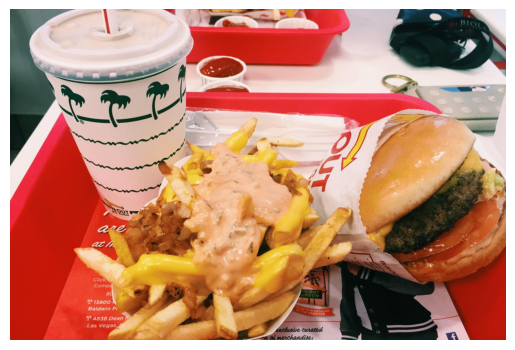

In [58]:
#while we are here, another way to use requests
image_url = "https://spoonuniversity.com/cdn-cgi/image/width=1020,height=680,fit=cover,format=auto/https://s3.amazonaws.com/secretsaucefiles/photos/images/000/020/134/original/1.jpg?1475173036g"

# Fetch the image
response = requests.get(image_url)
#response.raise_for_status()

# Open the image with PIL
yum = Image.open(BytesIO(response.content))

# Display in matplotlib
plt.imshow(yum)
plt.axis('off')  # hide axes
plt.show()